
# <font color=red><div align="center">Kaggle Machine Learning project</div></font>

### <font color=red><div align="center">17-02-2024</div></font>

# Imported libararies

In [22]:
import geopandas as gpd
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Data analysis

## 1. Loading data
Parsing huge geojson files is too much time consuming, that's why we decided to work with a csv format \
making loading and saving much faster.

In [2]:
# Try reading csv files if they exist
try: 
    train_df=pd.read_csv('./train.csv')
    test_df=pd.read_csv('./test.csv')
# If csv format not available, parse the json files 
# and convert them to csv for the next execution
except:
    train_df = gpd.read_file('./train.geojson', index_col=0)
    test_df = gpd.read_file('./test.geojson', index_col=0)

    train_df.to_csv('./train.csv', index=False)
    test_df.to_csv('./test.csv', index=False)

## 2. Analyzing features and classes
### Features
The training dataset includes 296146 data points each with 44 attributes: 
- Irregular Polygon object: storing coordinates of points and from which area, perimeter, \
and other geometrical characteristics can be computed (useful for later) 
- *Neighbourhood urban features* (e.g., the polygon is in a dense urban and industrial region).
- *Neighbourhood geographic features* (e.g., the polygon is near a river and a hill).
- Data from five different snapshots with their respective dates: 
    - date of each snapshot
    - Mean and standard deviation of the distribution of rgb colors at each date
    - The status of the area at each date

In [3]:
train_df.head(1)

,Unnamed: 0,urban_type,geography_type,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,...,date1,change_status_date1,date2,change_status_date2,date3,change_status_date3,date4,change_status_date4,index,geometry
0,0,Sparse Urban,"Dense Forest,Grass Land",Road,93.371775,107.291113,89.827379,29.81204,28.328368,25.324294,...,09-12-2013,Greenland,10-09-2016,Construction Started,22-07-2019,Construction Done,24-07-2017,Construction Midway,0,"POLYGON ((112.16774086470313 32.0219772550438,..."


### Features' distributions
We thought it would be informative to get an idea of the features' distribution in the dataset.\
Not only can it be used for some models like Bayes/MAP, but it can also make us spot imblanaces in the data. \

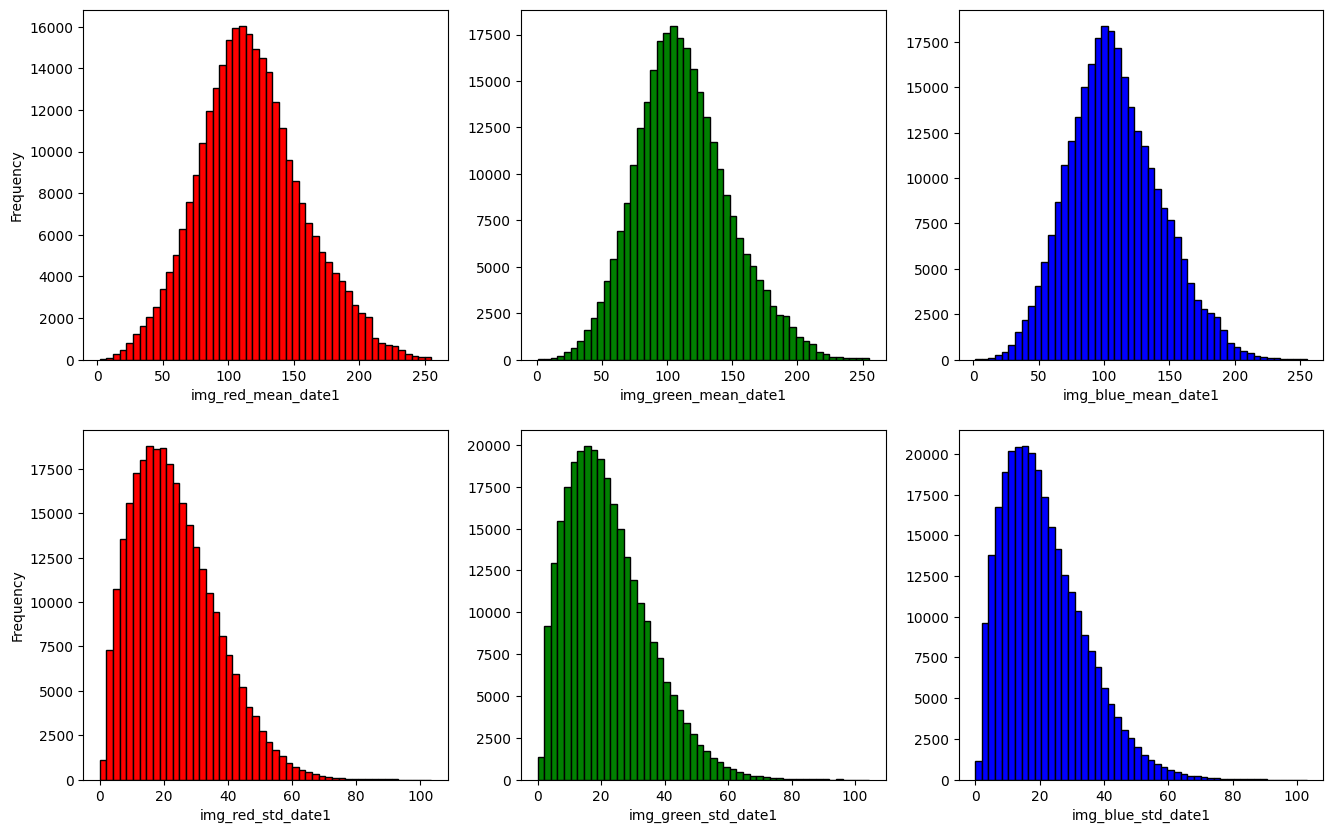

In [4]:
# Plotting the numerical values related to colors of date1
mean_columns=['img_red_mean_date1','img_green_mean_date1','img_blue_mean_date1']
std_columns=['img_red_std_date1','img_green_std_date1','img_blue_std_date1']
colors=['Red', 'Green', 'Blue']

plt.figure(figsize=(16, 10))
for i in range(3):
    # Plotting mean 
    plt.subplot(2, 3, i+1)
    plt.hist(train_df[mean_columns[i]], bins=50, color=colors[i], edgecolor='black')
    plt.xlabel(f'{mean_columns[i]}')
    if i==0:
        plt.ylabel('Frequency')
    # Plotting standard deviation 
    plt.subplot(2, 3, i+4)
    plt.hist(train_df[std_columns[i]], bins=50, color=colors[i], edgecolor='black')
    plt.xlabel(f'{std_columns[i]}')
    if i==0:
        plt.ylabel('Frequency')

### Classes
The goal is to classify this snapshot data into 6 classes corresponding to their changing type: \
Demolition, Road, Residential, Commercial, Industrial, Mega Projects. \
The following is a code visulizing the frequency distribution of these classes.


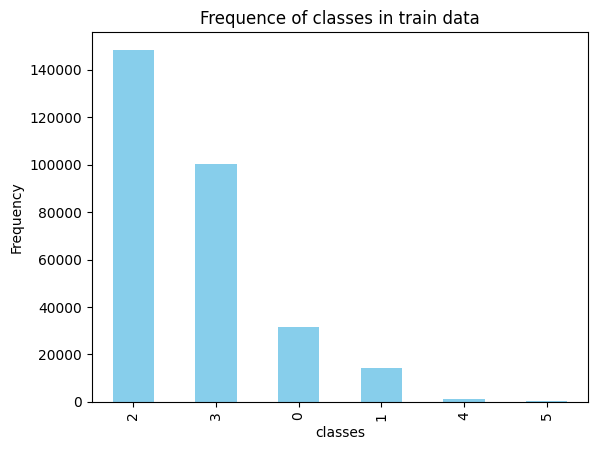

In [5]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
                   'Mega Projects': 5}

y_train = train_df['change_type'].apply(lambda x: change_type_map[x])

# Calculate the frequency of each class
classes_counts = y_train.value_counts()
# Plot a bar plot
classes_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('classes')
plt.ylabel('Frequency')
plt.title('Frequence of classes in train data')

# Show the plot
plt.show()

## 3. Remarks and conclusions
Taking a closer look at the features presented, there are few properties that come to mind:
- There are a few NA values.
- Some categorical features like *urban_type* involve combinations of different categories.
- Polygons are listed as abstract objects.
- Dates are in object format.
- Dates & dated features like *change_status_date* are not ordered row <b>and</b> column wise.
- Numerical features have gaussian distributions.
- Representations of different classes is imbalanced : *Residential* and *Commercial* types dominate the dataset.

# Data Processing
Any processing done to the training data has to be done to the test data as well,\
that's why it's better to write general functions instead of reapeating the code twice.

## 1. Label encoding
Turning categorical features into integer labels can be necessary for some models like *Neural Networks*, \
and makes categorical features that involve different combinations easier to handle in the case of *ubran_type* as an example.

In [6]:
def encode_labels(df):
    """
    Takes in a train or test dataframe df, and does the following:
    1. Expands urban_types and geography_types into boolean attributes (0 or 1)
    2. Encodes change_status_date as integer lablels (classes 0,1,2..etc)
    3. Drops old columns and concatenates new ones to the dataframe
    4. Returns a dataframe where categorical features are now numerically labeled
    """
    
    boolean_categories = ["urban_type", "geography_type"]
    for label in boolean_categories:
        # Splits combinations of types
        seperated_attributes = df[label].str.get_dummies(sep=',')
        full_df = pd.concat([seperated_attributes, df], axis=1)
        df = full_df.drop(label, axis=1)

    # Labeling change_status_dates 
    encoded_columns = [f'change_status_date{i}' for i in range(5)]
    change_status_map={}
    i=0
    for cat in encoded_columns:
        s=df[cat].unique()
        for val in s:
            if val not in change_status_map:
                change_status_map[val]=i
                i+=1
    for cat in encoded_columns:
        df[cat]=df[cat].apply(lambda x:change_status_map[x])
    return df

### Visualizing the encoding

In [7]:
categorical=["urban_type", "geography_type"]+[f"change_status_date{i}" for i in range(5)]
print('Categorical Columns')
train_df.head(1)

Categorical Columns


,Unnamed: 0,urban_type,geography_type,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,...,date1,change_status_date1,date2,change_status_date2,date3,change_status_date3,date4,change_status_date4,index,geometry
0,0,Sparse Urban,"Dense Forest,Grass Land",Road,93.371775,107.291113,89.827379,29.81204,28.328368,25.324294,...,09-12-2013,Greenland,10-09-2016,Construction Started,22-07-2019,Construction Done,24-07-2017,Construction Midway,0,"POLYGON ((112.16774086470313 32.0219772550438,..."


In [8]:
print("Encoded Columns")
test=train_df.head(1)
test=encode_labels(test)
test

Encoded Columns


,Dense Forest,Grass Land,Sparse Urban,Unnamed: 0,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,...,date1,change_status_date1,date2,change_status_date2,date3,change_status_date3,date4,change_status_date4,index,geometry
0,1,1,1,0,Road,93.371775,107.291113,89.827379,29.81204,28.328368,...,09-12-2013,1,10-09-2016,2,22-07-2019,0,24-07-2017,3,0,"POLYGON ((112.16774086470313 32.0219772550438,..."


## 2. Managing dates
This part constitutes the bulk of data processing where we will preform the following:\
1- Change the format of dates to datetime \
2- Order the dates and corresponding columns \
3- Compute the time interval between snapshots \
\
The latter turned out to be quite useful and it comes down to basic intuition: to predict types of construction,\
time intervals between snapshots is way more useful to the classifier than plain dates.

In [9]:
# Defining list of date columns e.g ['date1', 'date2'...]
dates_columns = [col for col in train_df.columns if col.startswith('date')]
# Defining a lists of dates and their corresponding features 
# [[features at date1],[features at date2]...]
dated_columns = [[f'date{x}', f'change_status_date{x}'] for x in range(5)]
for i in range(5):
    foo = [col for col in train_df.columns if col.startswith('img_')]
    dated_columns[i] += [col for col in foo if col.endswith(f'date{i+1}')]

# Ordering date values in a row
def order_row(row):
    """
    Takes in a row, reads dated values
    and returns a row that is sorted by date
    """

    # Reading and storing dated columns' values
    values = []
    for date in dated_columns:
        date_values = []
        for col in date:
            date_values.append(row[col])
        values.append(date_values)

    # Ordering values by date
    values = sorted(values, key=lambda x: x[0])

    # Reinserting ordered values
    for i in range(5):
        date = dated_columns[i]
        for j in range(len(date)):
            col = date[j]
            row[col] = values[i][j]
    return row

def transform_dates(df):
    """
    Takes a dataframe, and does the following:
    1. Turn dates into datetime
    2. Order dates and corresponding features 
    3. Compute the time intervals between each snapshot
    4. Drops dates
    5. Returns a dataframe with a reference date t0 and time intervals columns added
    """
    # Turning dates into datetime
    _ = df[dates_columns].apply(
        lambda col: pd.to_datetime(col, format='%d-%m-%Y'))
    df[dates_columns]=_
    
    
    # Ordering the dataframe
    df = df.apply(order_row, axis=1)

    # Setting a reference date older than all dates
    date_ref = pd.to_datetime(
        pd.Series(['01-01-2000'] * len(df)), format='%d-%m-%Y')
    
    # Compute difference of consecutive dates to get time intervals
    # While treating the None values
    for i in range(len(dates_columns)-1):
        try:
            df[f'delta{i+1}'] = (df[f'date{i+1}']-df[f'date{i}']).dt.days/365
        except: 
            df[f'delta{i+1}'] = None
    try:
        df['t0'] = (df['date0']-date_ref).dt.days/365
    except:
        df['t0'] = None

    # Dropping dates
    for date in dates_columns:
        df=df.drop(date, axis=1) 
    return df

### Visulizing sorted dates

In [10]:
print("Unsorted dates")
test=train_df.head(1)
test[dates_columns+[dated_columns[0][1]]]

Unsorted dates


,date0,date1,date2,date3,date4,change_status_date0
0,01-08-2018,09-12-2013,10-09-2016,22-07-2019,24-07-2017,Construction Done


In [11]:
print("Transformed dates and duration of changes")
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    test=transform_dates(test)
test[['t0']+[f'delta{i}' for i in range(1,5)]+[dated_columns[0][1]]]

Transformed dates and duration of changes


,t0,delta1,delta2,delta3,delta4,change_status_date0
0,13.947945,2.756164,0.868493,1.021918,0.972603,Greenland


## 3. Extracting new features from Polygons
Given we can't train with abstract class objects like Polygons, we need to extract \
real valued information from them. To conserve as much as we can, we decided to create \
new columns of every geometrical proprety : 
- Area
- Perimeter
- Centroid_x (longetitude)
- Centroid_y (latitude)
- Number of sides

In [12]:
def extract_geometry(df):
    polygons = gpd.GeoSeries.from_wkt(df["geometry"])
    area = polygons.apply(lambda x: x.area)
    centroid_x = polygons.apply(lambda x: x.centroid.x)
    centroid_y = polygons.apply(lambda x: x.centroid.y)
    perimeter = polygons.apply(lambda x: x.length)
    n_sides = polygons.apply(lambda x: len(x.exterior.coords))
    df['area'] = area
    df['centroid_x'] = centroid_x
    df['centroid_y'] = centroid_y
    df['perimeter'] = perimeter
    df['n_sides'] = n_sides
    df=df.drop('geometry', axis=1)
    return df

## 4. Data cleaning : dealing with NA values
After all the transformations done above, our dataset is still messy due to None values \
and literal 'N,A' categories that spawn new columns 'N' and 'A' after our label encoding. \
\
Both testing data and training data have these *holes* in them, e.i data points which don't contain \
all the features, given we need to produce results even with these data points we decided it's better to \
fill in the gaps with averages of each column and drop unimportant columns to not interfer with training.

In [13]:
def cleanup(df):
    ToBeDropped=['Unnamed: 0', 'index', 'N', 'A']
    for col in ToBeDropped:
        if col in df.columns:
            df=df.drop(col, axis=1)
    # Labeling classes in case of train dataframe
    if 'change_type' in df.columns: 
        df['change_type']=df['change_type'].apply(lambda x : change_type_map[x])
    # Filling na
    df=df.fillna((df.mean()))
    return df

## Processed datasets
Applying all these steps to process each of the train and test dataframes makes us \
ready to train some models and get results.

In [14]:
def process(df):
    df=encode_labels(df)
    df=transform_dates(df)
    df=extract_geometry(df)
    df=cleanup(df)
    return df
train_df=process(train_df)
test_df=process(test_df)
train_df.head(5)

,Barren Land,Coastal,Dense Forest,Desert,Farms,Grass Land,Hills,Lakes,River,Snow,...,delta1,delta2,delta3,delta4,t0,area,centroid_x,centroid_y,perimeter,n_sides
0,0,0,1,0,0,1,0,0,0,0,...,2.756164,0.868493,1.021918,0.972603,13.947945,8.174601e-07,112.168360,32.021327,0.004137,5
1,0,0,1,0,0,1,0,0,0,0,...,2.756164,0.868493,1.021918,0.972603,13.947945,4.394334e-07,112.168931,32.020195,0.002746,5
2,0,0,1,0,0,1,0,0,0,0,...,2.756164,0.868493,1.021918,0.972603,13.947945,8.209702e-07,112.169502,32.019024,0.004280,5
3,0,0,1,0,0,1,0,0,0,0,...,2.756164,0.868493,1.021918,0.972603,13.947945,8.175168e-07,112.170235,32.017493,0.004168,5
4,0,0,1,0,1,0,0,0,0,0,...,2.756164,0.868493,1.021918,0.972603,13.947945,1.484970e-07,112.167037,32.015908,0.001741,5


# Training models
Given that this is a non-linear classification problem, we decided to test the following 3 models. \
But first we need to split our training dataset since we don't have labels for the given test dataset.

In [24]:
# labels of the original train dataset
y_train=train_df['change_type']
train_df=train_df.drop('change_type', axis=1)

# Split of the train dataframe
X_train, X_test, Y_train, Y_test=train_test_split(train_df, y_train, test_size=0.2, random_state=42)


## 1. K-Nearest Neighbhors 

In [25]:
# In the course, a rule of thumb in choosing k
# is to to choose the sqrt of the number of instances
rule_of_thumb=int(np.sqrt(len(X_train)))

random_k_values = [3,12,35,50,80, rule_of_thumb]
                                                    
# Find the best k value among the randomly selected values
best_score = 0
best_k = 0
for k in random_k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, Y_train)
    Y_pred = neigh.predict(X_test)
    score=accuracy_score(Y_test, Y_pred)
    print(f"Testing {k} gives : {round(10000*score)/100} %")
    if score> best_score:
        best_score = score
        best_k = k

print("Best k found:", best_k)

# Train the model with the best k value
best_neigh = KNeighborsClassifier(n_neighbors=best_k)
best_neigh.fit(X_train, Y_train)

# Predict on the test set
Y_pred = best_neigh.predict(X_test)
print(f"Best accuracy: {round(10000*accuracy_score(Y_test, Y_pred))/100} %")


Testing 3 gives : 60.35 %
Testing 12 gives : 63.78 %
Testing 35 gives : 63.22 %
Testing 50 gives : 62.73 %
Testing 80 gives : 62.01 %
Testing 486 gives : 58.73 %
Best k found: 12
Best accuracy: 63.78 %


## 2. Random forest
Using a random forest on the preprocessed data gave us by far the best accuracy on Kaggle (97.185 %). \
The following code executes and saves predictions on the original test data.

In [26]:

# Initialize the Random Forest classifier using default parameter 
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_classifier.fit(train_df, y_train)

# Predict the target variable on the test data
y_pred = rf_classifier.predict(test_df)

# Saving predictions
pred_df = pd.DataFrame(y_pred, columns=['change_type'])
pred_df.to_csv("RF_sample_submission.csv", index=True, index_label='Id')

## 3. Neural Networks

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_train=train_df.copy()
df_test=test_df.copy()

# Normalize the data
df_train_normalized = scaler.fit_transform(df_train)
df_test_normalized = scaler.fit_transform(df_test)

# Create a pandas DataFrame with the normalized data
train_normalized_df = pd.DataFrame(df_train_normalized, columns=df_train.columns)
test_normalized_df = pd.DataFrame(df_test_normalized, columns=df_test.columns)
 
X = train_normalized_df 
y = train_df['change_type']
# Normaliser les données si nécessaire (peut être omis si les données sont déjà normalisées)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Définir le modèle MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(50, 30), activation='relu', 
                      solver='adam', alpha=0.0001, batch_size='auto', 
                      learning_rate='constant', learning_rate_init=0.001, max_iter=100)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.2f}')

# Fine tuning 
Based on the tests done above, we settle on RandomForest as the main model. \
In this section we try to explore methods to fine tune and squeeze the best we can out of this model.

## 1. Undersampled and Oversampling data
We saw that the data is unblanaced when it comes to classes, maybe we can improve on it.

### Overdersampled data

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

data = train_df.copy()

# split the data into features X_train and target variable y_train
X_train = data.drop(['change_type'], axis=1)
y_train = data['change_type']

ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)



In [ ]:
# Calculate the frequency of each class
classes_counts_os = y_train_os.value_counts()
# Plot a bar plot
classes_counts_os.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('classes')
plt.ylabel('Frequency')
plt.title('Frequence of classes in train data oversampled')

# Show the plot
plt.show()

According to Kaggle, oversampled data gave us an accuracy of : 61.669 %

### Undersampled data

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

# define test features X_test
X_test = test_df


# Initialize the Random Forest classifier using default parameter 
rf_classifier_us = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_classifier_us.fit(X_train_us, y_train_us)

# Predict the target variable on the test data
y_pred_us = rf_classifier_us.predict(X_test)

In [ ]:
# Calculate the frequency of each class
classes_counts_us = y_train_us.value_counts()
# Plot a bar plot
classes_counts_us.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('classes')
plt.ylabel('Frequency')
plt.title('Frequence of classes in train data undersampled')

# Show the plot
plt.show()


According to Kaggle, undersampled data gave us an accuracy of : 21.53 %

## 2. Predictive features 
Here we use MDI to extract feature importance in the random forest, and then we try it on the model using only the most important features.

In [ ]:
feature_names = X_train.columns
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

clf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
clf_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
X_train_new = data[['img_red_mean_date1', 'img_green_mean_date1',
       'img_blue_mean_date1', 'img_red_std_date1', 'img_green_std_date1',
       'img_blue_std_date1', 'img_red_mean_date2', 'img_green_mean_date2',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_mean_date3', 'img_green_mean_date3',
       'img_blue_mean_date3', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5', 'change_status_date0', 'change_status_date1',
       'change_status_date2', 'change_status_date3', 'change_status_date4',
       'delta1', 'delta2', 'delta3', 'delta4', 't0', 'centroid_x',
       'centroid_y', 'perimeter', 'n_sides']]

y_train_new = data['change_type']


# Initialize the Random Forest classifier using default parameter 
rf_classifier_new = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_classifier_new.fit(X_train_new, y_train_new)

# Predict the target variable on the test data
y_pred_new = rf_classifier_new.predict(X_test[['img_red_mean_date1', 'img_green_mean_date1',
       'img_blue_mean_date1', 'img_red_std_date1', 'img_green_std_date1',
       'img_blue_std_date1', 'img_red_mean_date2', 'img_green_mean_date2',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_mean_date3', 'img_green_mean_date3',
       'img_blue_mean_date3', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5', 'change_status_date0', 'change_status_date1',
       'change_status_date2', 'change_status_date3', 'change_status_date4',
       'delta1', 'delta2', 'delta3', 'delta4', 't0', 'centroid_x',
       'centroid_y', 'perimeter', 'n_sides']])


Accuracy : ~0.5

## 3. Parameter tuning
Here we try to test different parameters of the model, but turns out that apparently the default parameters are better.\
Heads up this code takes a loooong time might as well take our word for it lol.

In [ ]:
from sklearn.model_selection import GridSearchCV

# parameters of  grid to search

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required at each leaf node
}

# Instantiate the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=4, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)  

# Print the best cross-validation score found
print("Best cross-validation score:", grid_search.best_score_)